In [1]:
import torch 
import torchvision
import torchvision.transforms as tr
import torchvision.datasets as dset
from torch.utils.data import DataLoader, Dataset

from torch.autograd import Variable
from torch.autograd import Function

import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random

import visdom
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
vis = visdom.Visdom()
vis2 = visdom.Visdom()
plot = vis.line(Y=torch.tensor([0]), X=torch.tensor([0]))
plot2= vis2.line(Y=torch.tensor([0]),X=torch.tensor([0]))

Setting up a new session...
Setting up a new session...


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
transf = tr.Compose([tr.Resize((128, 128)),
                     tr.ToTensor(),
                     tr.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 128x128 이미지 크기 변환 후 텐서 제작
image_datasets = torchvision.datasets.ImageFolder(root='./CNN', transform=transf) # 4번 검사 데이터 데이터 로딩
print(image_datasets)

Dataset ImageFolder
    Number of datapoints: 666
    Root location: ./CNN
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
class_names = image_datasets.classes
print(class_names)

['Deform&PSV', 'Deformed', 'Normal', 'PSV']


In [7]:
train_size = int(0.7 * len(image_datasets))
test_size = len(image_datasets) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
validation_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

In [8]:
def imshow(inp, title=None):
    #Imshow for Tensor#
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [9]:
inputs, classes = next(iter(train_loader))
print(classes)

tensor([2, 2, 3, 2, 2, 3, 2, 2])


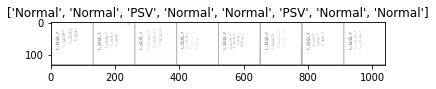

In [10]:
out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [11]:
model = torchvision.models.resnet18(pretrained=True)

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 4) # fc를 nn.Linear(num_ftrs, 10)로 대체한다.
model = model.to(device)

In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# 손실함수, 최적화 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [16]:
for epoch in range(5):

    running_loss = 0.0
    correct = 0
    for data in train_loader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()

    cost = running_loss / len(train_loader)        
    print('[%d] loss: %.3f' %(epoch + 1, cost))  
    
    #test loss 값을 Y축, 전달받은 파라미터 epoch를 X 값으로 
    vis.line(Y=[cost], X=np.array([epoch]),win=plot,update='append')
    
    # accuracy를 구하는 수식을 Y값으로 epoch를 X값으로 
    vis2.line(Y=[100.*correct/len(validation_loader.dataset)], X=np.array([epoch]),win=plot2,update='append')
    
torch.save(model.state_dict(), './models/test4_resnet18.pth')      

print('Finished Training')

[1] loss: 0.629
[2] loss: 0.309
[3] loss: 0.265
[4] loss: 0.151
[5] loss: 0.094
Finished Training


In [17]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 
model = model.to(device)
model.load_state_dict(torch.load('./models/test4_resnet18.pth'))

<All keys matched successfully>

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 86 %
